In [1]:
import s2cloudless
import gdal
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [17]:
# Класс-обёртка для подготовки, запуска и экспорта 

class S2CloudDetectorUtil():
    
    def __init__(self, s2_safe_directory, resolution='60m'):
        self.s2_safe_directory = s2_safe_directory
        self.full_array, self.etalon_ds = self.prepare_s2_scene(self.s2_safe_directory, resolution=resolution)
    
    def detect_clouds(self, threshold=0.4, average_over=4, dilation_size=2):
        self.cloud_detector = s2cloudless.S2PixelCloudDetector(threshold=threshold, average_over=average_over, dilation_size=dilation_size)
        self.cloud_probs = self.cloud_detector.get_cloud_probability_maps(np.array([self.full_array]))[0]
        self.cloud_mask = np.zeros_like(self.cloud_probs)
        self.cloud_mask[self.cloud_probs>=threshold] = 1
    
    def export_to_gtiff(self, output_gtiff, mode='probs'):
        if mode == 'probs':
            export_array = self.cloud_probs
        if mode == 'mask':
            export_array = self.cloud_mask
        
        geoTransform = self.etalon_ds.GetGeoTransform()
        projection = self.etalon_ds.GetProjection()
        xSize = self.etalon_ds.RasterXSize
        ySize = self.etalon_ds.RasterYSize
        if mode =='probs':
            data_type = gdal.GDT_Float32
        if mode =='mask':
            data_type = gdal.GDT_Byte

        drv = gdal.GetDriverByName('GTiff')
        new_ds = drv.Create(output_gtiff, xSize, ySize, 1, data_type)
        new_ds.SetGeoTransform(geoTransform)
        new_ds.SetProjection(projection)
        new_ds.GetRasterBand(1).WriteArray(export_array)
        del new_ds
        
    def draw_plot(self,mode='probs'):
        if mode == 'probs':
            export_array = self.cloud_probs
        if mode == 'mask':
            export_array = self.cloud_mask
        
        plt.close()
        plt.imshow(export_array)
        plt.colorbar()
        plt.show()
    
    def prepare_s2_scene(self, s2_safe_directory, resolution='60m'):
        if os.path.basename(s2_safe_directory).find('MSIL1C_') != -1:
            level = 'L1C'
        elif os.path.basename(s2_safe_directory).find('MSIL2A_') != -1:
            level = 'L2A'
            raise TypeError('L2A is not supported by algorithm :(')
        else:
            return None

        if level == 'L1C':
            B01 = self.find_file_end_with(s2_safe_directory,'B01.jp2')[0]
            B02 = self.find_file_end_with(s2_safe_directory,'B02.jp2')[0]
            B04 = self.find_file_end_with(s2_safe_directory,'B04.jp2')[0]
            B05 = self.find_file_end_with(s2_safe_directory,'B05.jp2')[0]
            B08 = self.find_file_end_with(s2_safe_directory,'B08.jp2')[0]
            B8A = self.find_file_end_with(s2_safe_directory,'B8A.jp2')[0]
            B09 = self.find_file_end_with(s2_safe_directory,'B09.jp2')[0]
            B10 = self.find_file_end_with(s2_safe_directory,'B10.jp2')[0]
            B11 = self.find_file_end_with(s2_safe_directory,'B11.jp2')[0]
            B12 = self.find_file_end_with(s2_safe_directory,'B12.jp2')[0]

            list_of_bands = [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]

        #if level == 'L2A':
        #    B01 = self.find_file_end_with(s2_safe_directory,'B01_60m.jp2')[0]
        #    B02 = self.find_file_end_with(s2_safe_directory,'B02_10m.jp2')[0]
        #    B04 = self.find_file_end_with(s2_safe_directory,'B04_10m.jp2')[0]
        #    B05 = self.find_file_end_with(s2_safe_directory,'B05_20m.jp2')[0]
        #    B08 = self.find_file_end_with(s2_safe_directory,'B08_10m.jp2')[0]
        #    B8A = self.find_file_end_with(s2_safe_directory,'B8A_20m.jp2')[0]
        #    B09 = self.find_file_end_with(s2_safe_directory,'B09_60m.jp2')[0]
        #    B11 = self.find_file_end_with(s2_safe_directory,'B11_20m.jp2')[0]
        #    B12 = self.find_file_end_with(s2_safe_directory,'B12_20m.jp2')[0]

        if resolution == '60m':
            etalon_ds = gdal.Open(B01)
        if resolution == '20m':
            etalon_ds = gdal.Open(B05)
        if resolution == '10m':
            etalon_ds = gdal.Open(B02)
                
        geoTransform = etalon_ds.GetGeoTransform()
        projection = etalon_ds.GetProjection()
        xMin = geoTransform[0]
        yMax = geoTransform[3]
        xMax = xMin + geoTransform[1] * etalon_ds.RasterXSize
        yMin = yMax + geoTransform[5] * etalon_ds.RasterYSize
        xSize = etalon_ds.RasterXSize
        ySize = etalon_ds.RasterYSize
        
        full_array = []

        for band in list_of_bands:
            print ('Process band %s' % band)
            if level == 'L1C':
                band_ds = gdal.Warp('', band, format='MEM',outputBounds = [xMin,yMin,xMax,yMax], width=xSize, height=ySize)
            #if level == 'L2A':
            #    band_ds = gdal.Open(band)

            band_array = band_ds.GetRasterBand(1).ReadAsArray()
            if full_array == []:
                full_array = band_array / 10000.0
            else:
                full_array = np.dstack([full_array, band_array / 10000.0])
                del band_array
                del band_ds

        return full_array, etalon_ds
    
    def find_file_end_with(self, base_dir, end_with):
        cfiles = []
        for root, dirs, files in os.walk(base_dir):
            for file in files:
                if file.endswith(end_with):
                    cfiles.append(os.path.join(root, file))
        return cfiles

Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B01.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B02.jp2


<ipython-input-17-45b0d603f3d8>:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if full_array == []:


Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B04.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B05.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B08.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B8A.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B09.jp2
Process band F:\Projects\S2_cloud_masking\S2B

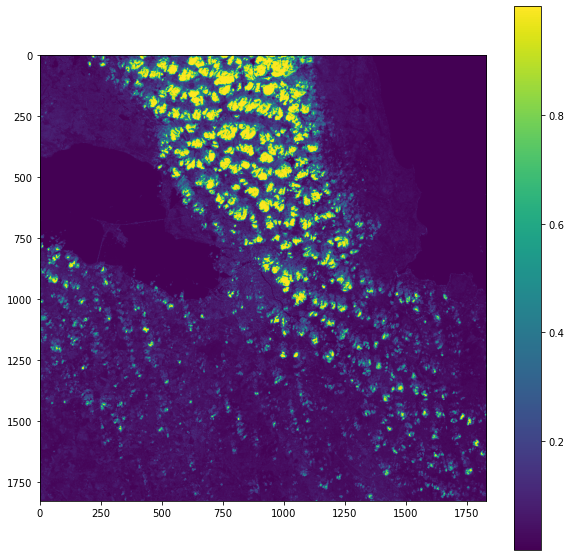

Wall time: 24.8 s


In [18]:
%%time

# L1C
# 60m
u = S2CloudDetectorUtil('F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE', resolution='60m')
u.detect_clouds()
u.export_to_gtiff(output_gtiff='L1C_60m_probs.tif', mode='probs')
u.export_to_gtiff(output_gtiff='L1C_60m_mask.tif', mode='mask')
u.draw_plot()

Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B01.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B02.jp2


<ipython-input-17-45b0d603f3d8>:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if full_array == []:


Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B04.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B05.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B08.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B8A.jp2
Process band F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE\GRANULE\L1C_T36VUM_A016464_20200501T093030\IMG_DATA\T36VUM_20200501T093029_B09.jp2
Process band F:\Projects\S2_cloud_masking\S2B

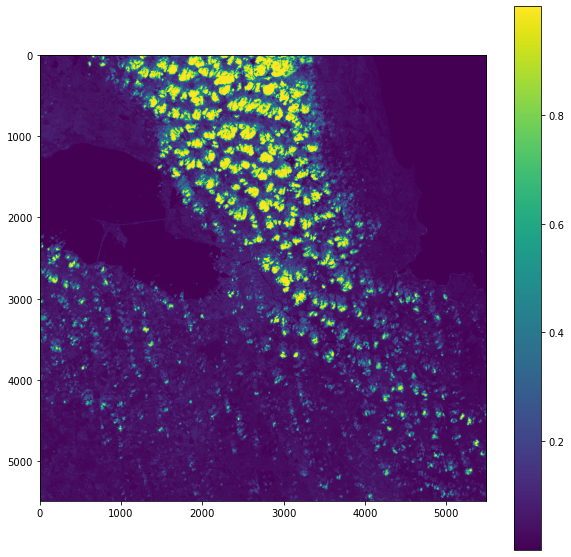

Wall time: 3min 22s


In [19]:
%%time

# L1C
# 20m
u = S2CloudDetectorUtil('F:\Projects\S2_cloud_masking\S2B_MSIL1C_20200501T093029_N0209_R136_T36VUM_20200501T104534.SAFE', resolution='20m')
u.detect_clouds()
u.export_to_gtiff(output_gtiff='L1C_20m_probs.tif', mode='probs')
u.export_to_gtiff(output_gtiff='L1C_20m_mask.tif', mode='mask')
u.draw_plot()